In [ ]:
import chainer.serializers
chainer.serializers.load_npz('micro_generator',generator)
chainer.serializers.load_npz('micro_discriminator',discriminator)
###### you could directly use the generator and discriminator after loading

In [66]:
import scipy.io as sio
xtr=sio.loadmat('xtr30_left.mat')['xtr_left']
xtr=xtr.T

In [67]:
import argparse
import numpy as np
from chainer import datasets, cuda, serializers, Variable
from chainer import optimizers as O
from chainer import functions as F
from models import Generator, Discriminator


# def rnd_categorical(n, n_categorical):
#     indices = np.random.randint(n_categorical, size=n)
#     one_hot = np.zeros((n, n_categorical))
#     one_hot[np.arange(n), indices] = 1
#     return one_hot, indices


def rnd_categorical(n, n_categorical,xtr):
    indices = np.random.randint(n_categorical, size=n)
    one_hot = np.zeros((n, 30))
    for i in range(n):
        one_hot[i, :]=xtr[indices[i]]
    return one_hot, indices


def rnd_continuous(n, n_continuous, mu=0, std=1):
    return np.random.normal(mu, std, size=(n, n_continuous))



#args = parse_args()
#gpu = args.gpu
n_z = 0
n_categorical = len(xtr)
n_continuous = 2
max_epochs = 10000
batch_size = 100
#out_generator_filename = args.out_generator_filename

# Prepare the training data
#     train, _ = datasets.get_mnist(withlabel=False, ndim=2)
#     train_size = train[0:1000].shape[0]
#     im_shape = train.shape[1:]

import scipy.io as sio
image = sio.loadmat('WB_test28_GAN.mat')
data1=np.abs(image['WB_test28_GAN'])
train=data1/1.
train=train.reshape(100,28,28)
train_size = train[0:100].shape[0]
im_shape = train.shape[1:]


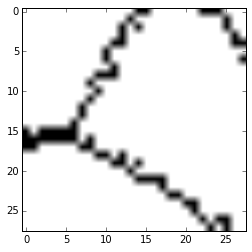

In [68]:
import random
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(data1[0].reshape(28,28),'gray')

In [88]:
# Prepare the models
generator = Generator(n_z + 30 + n_continuous, im_shape)
generator_optimizer = O.Adam(alpha=1e-3, beta1=0.5)
generator_optimizer.setup(generator)

discriminator = Discriminator(im_shape, n_categorical, n_continuous)
discriminator_optimizer = O.Adam(alpha=2e-4, beta1=0.5)
discriminator_optimizer.setup(discriminator)

xp = np

for epoch in range(max_epochs):
    generator_epoch_loss = np.float32(0)
    discriminator_epoch_loss = np.float32(0)

    for i in range(0, train_size, batch_size):
        # Sample noise z
        zs = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)

        # Sample a category encoded as a one-hot vector to hopefully learn a digit
        c_categorical, categories = rnd_categorical(batch_size, n_categorical,xtr)
        
        c_categorical = xp.asarray(c_categorical, dtype=xp.float32)
        categories = xp.asarray(categories, dtype=xp.int32)

        # Sample continuous codes to learn rotation, thickness, etc.
        c_continuous = xp.asarray(rnd_continuous(batch_size, n_continuous), dtype=xp.float32)

        zc = xp.concatenate((zs, c_categorical, c_continuous), axis=1)

        # Forward
        x_fake = generator(zc)
        y_fake, mi = discriminator(x_fake)

        x_real = xp.zeros((batch_size, 28,28), dtype=xp.float32)
        for xi in range(len(x_real)):
            x_real[xi] = xp.array(train[np.random.randint(train_size)])
        
        x_real = xp.expand_dims(x_real, 1)
        y_real, _ = discriminator(x_real)

        # Losses
        generator_loss = F.softmax_cross_entropy(y_fake, xp.ones(batch_size, dtype=xp.int32))
        discriminator_loss = F.softmax_cross_entropy(y_fake, xp.zeros(batch_size, dtype=xp.int32))
        discriminator_loss += F.softmax_cross_entropy(y_real, xp.ones(batch_size, dtype=xp.int32))

        # Mutual Information loss
        mi_categorical, mi_continuous_mean = F.split_axis(mi, [n_categorical], 1)

        # Categorical loss
        categorical_loss = F.softmax_cross_entropy(mi_categorical, categories, use_cudnn=False)

        # Continuous loss - Fix standard deviation to 1, i.e. log variance is 0
        mi_continuous_ln_var = xp.empty_like(mi_continuous_mean.data, dtype=xp.float32)
        mi_continuous_ln_var.fill(1)
        # mi_continuous_ln_var.fill(1e-6)
        continuous_loss = F.gaussian_nll(mi_continuous_mean, Variable(c_continuous), Variable(mi_continuous_ln_var))
        continuous_loss /= batch_size

        generator_loss += categorical_loss
        generator_loss += continuous_loss

        # Backprop
        generator_optimizer.zero_grads()
        generator_loss.backward()
        generator_optimizer.update()

        discriminator_optimizer.zero_grads()
        discriminator_loss.backward()
        discriminator_optimizer.update()

        generator_epoch_loss += generator_loss.data
        discriminator_epoch_loss += discriminator_loss.data

    generator_avg_loss = generator_epoch_loss / train_size
    discriminator_avg_loss = discriminator_epoch_loss / train_size

    print('Epoch {} Loss Generator: {} Loss Discriminator: {}'
          .format(epoch + 1, generator_avg_loss, discriminator_avg_loss))


print('Finished training')

Epoch 1 Loss Generator: 0.0604029846191 Loss Discriminator: 0.00185274541378
Epoch 2 Loss Generator: 0.0607358551025 Loss Discriminator: 0.00181107699871
Epoch 3 Loss Generator: 0.0598514986038 Loss Discriminator: 0.00185916095972
Epoch 4 Loss Generator: 0.0605396175385 Loss Discriminator: 0.00178176641464
Epoch 5 Loss Generator: 0.0606541442871 Loss Discriminator: 0.00176235496998
Epoch 6 Loss Generator: 0.0606077718735 Loss Discriminator: 0.00174474895
Epoch 7 Loss Generator: 0.0612064552307 Loss Discriminator: 0.00162686213851
Epoch 8 Loss Generator: 0.0609292888641 Loss Discriminator: 0.00168922245502
Epoch 9 Loss Generator: 0.0604650783539 Loss Discriminator: 0.00164164453745
Epoch 10 Loss Generator: 0.0622824048996 Loss Discriminator: 0.0015881793201
Epoch 11 Loss Generator: 0.0621891355515 Loss Discriminator: 0.00155769273639
Epoch 12 Loss Generator: 0.0611896896362 Loss Discriminator: 0.00154326692224
Epoch 13 Loss Generator: 0.0619883346558 Loss Discriminator: 0.00140379071236

KeyboardInterrupt: 

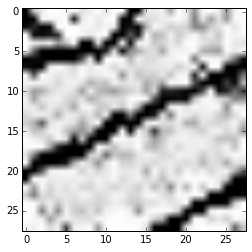

In [181]:
import random
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(generator(zc).data[0].reshape(28,28),'gray')

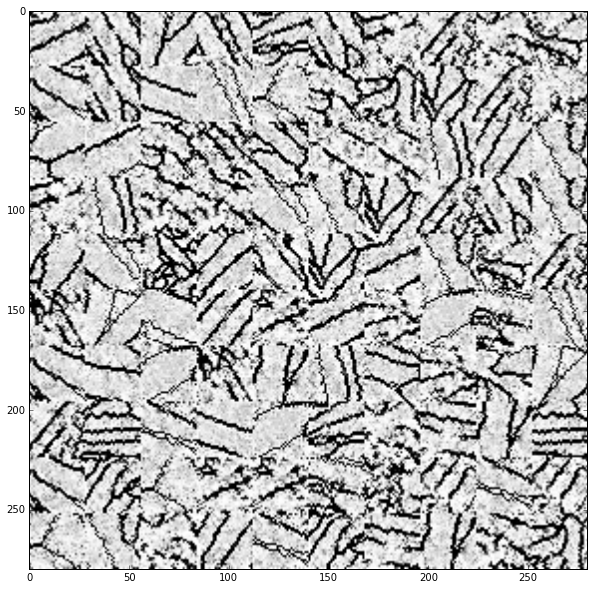

In [90]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)

#z=np.random.uniform(-1, 1, (100, 62)).astype(np.float32)

c2=np.zeros((100,2))
grid_y = np.linspace(-1, 1, 10)
for j, xi in enumerate(grid_y):
    c2[j,0]=xi
        
#for i, yi in enumerate(grid_x):
for j, xi in enumerate(grid_y):
    for i, yi in enumerate(grid_x):
        z=np.random.uniform(-1, 1, (100, 0)).astype(np.float32)
        c1=np.zeros((100,n_categorical))
        c1[:,1]=1
        c2=xp.asarray(rnd_continuous(100, n_continuous), dtype=xp.float32)
        z_test = np.concatenate((z, c1, c2), axis=1)
        z_sample = zc
        z_sample=z_sample.astype(np.float32)
        #print i
        x_decoded = generator(z_sample).data[i+j*10]
        digit = x_decoded.reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size, j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

In [123]:
ii//9

65

In [125]:
c_categorical2 = np.zeros((650,30), dtype=np.float32)
for ii in range(650):
    ii_temp=ii//10
    c_categorical2[ii,:]=xtr[ii_temp]

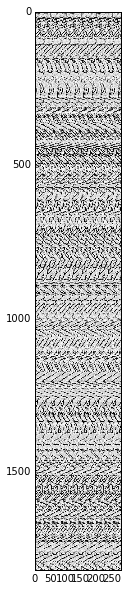

In [126]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * 65, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, 65)
grid_y = np.linspace(-1, 1, n)
zs2 = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)

c_categorical2 = np.zeros((650,30), dtype=np.float32)
for ii in range(650):
    ii_temp=ii//10
    c_categorical2[ii,:]=xtr[ii_temp]


c_continuous2 = xp.asarray(rnd_continuous(650, n_continuous), dtype=xp.float32)
c_continuous2[0,:] = 0
        
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #c_continuous2=np.zeros((100,n_continuous),dtype=np.float32)
        c_continuous2[0,:]=np.array([[0, yi]], dtype=np.float32)
        c_categorical2[0]=c_categorical2[j+10*i]
        zc2 = xp.concatenate((c_categorical2, c_continuous2), axis=1)  
        x_decoded = generator(zc2).data[0]
        digit = x_decoded.reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

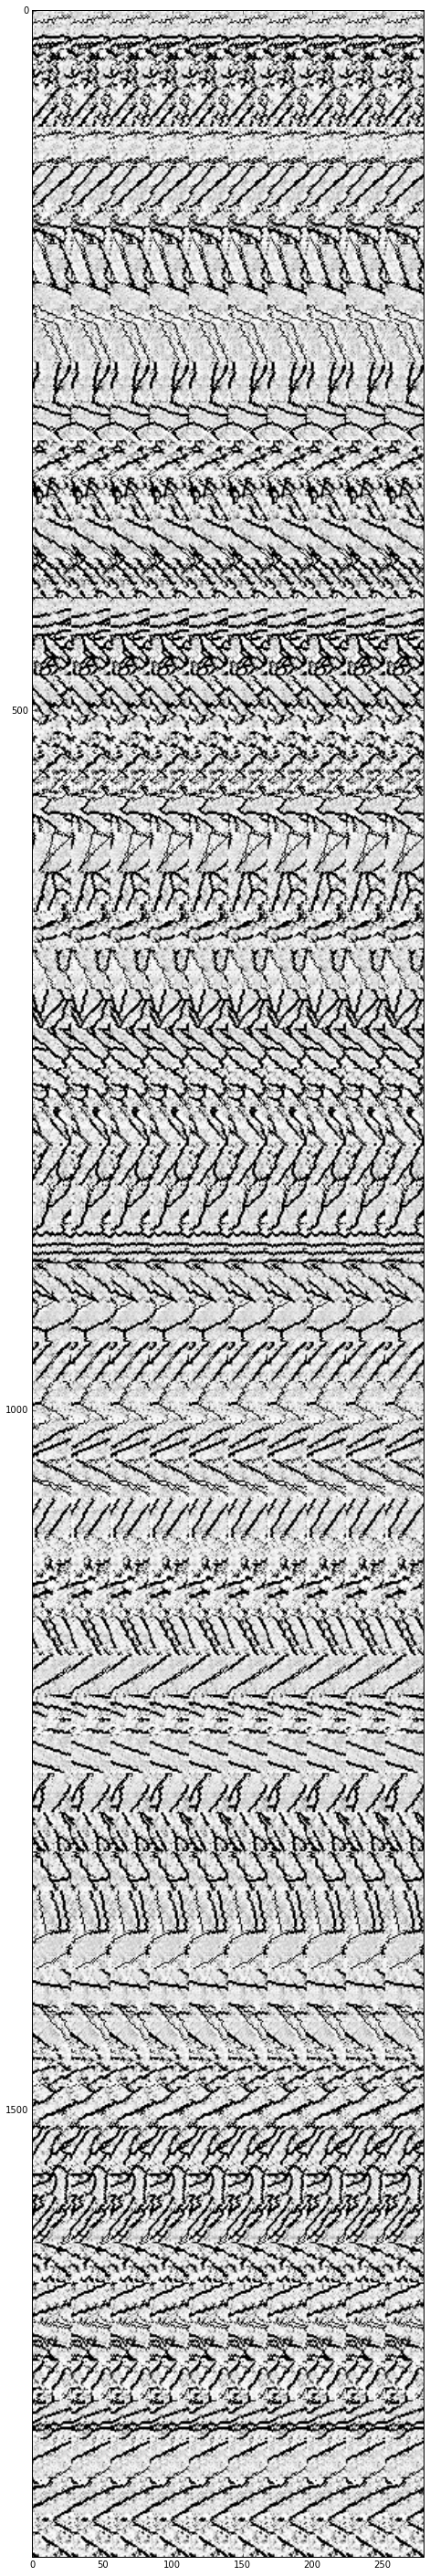

In [128]:
plt.figure(figsize=(50, 50))
plt.imshow(figure,'gray')
plt.show()

In [187]:
test=np.zeros((100,30))
for j in range(100):
    for i in range(30):
        roll=random.randint(1,10)
        if roll >=5:
            test[j,i]=1
                

In [184]:
c_categorical2 = np.zeros((batch_size,30), dtype=np.float32)
for ii in range(100):
    roll=random.randint(0,n_categorical-1)
    c_categorical2[ii]=xtr[roll]
c_categorical2[0,:]=0
c_categorical2[0,:]=xtr[0]

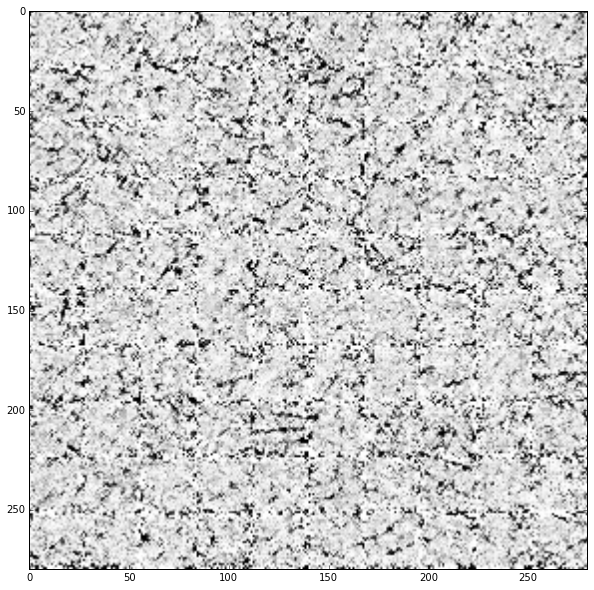

In [189]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)
zs2 = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)

# c_categorical2 = np.zeros((batch_size,30), dtype=np.float32)
# for ii in range(100):
#     roll=random.randint(0,n_categorical-1)
#     c_categorical2[ii]=xtr[roll]
# c_categorical2[0,:]=0
# c_categorical2[0,:]=xtr[0]

c_continuous2 = xp.asarray(rnd_continuous(100, n_continuous), dtype=xp.float32)
c_continuous2[0,:] = 0
        
for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        c_continuous2=np.zeros((100,n_continuous),dtype=np.float32)
        c_continuous2[0,:]=np.array([[0, 0]], dtype=np.float32)
        #c_categorical2[0]=abs(1-c_categorical2[j+10*i]) #abs(1-test[j+10*i])
        c_categorical2[0]=test[j+10*i]
        zc2 = xp.concatenate((c_categorical2, c_continuous2), axis=1)  
        x_decoded = generator(zc2).data[0]
        digit = x_decoded.reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

In [196]:
zc2.shape

(100L, 32L)

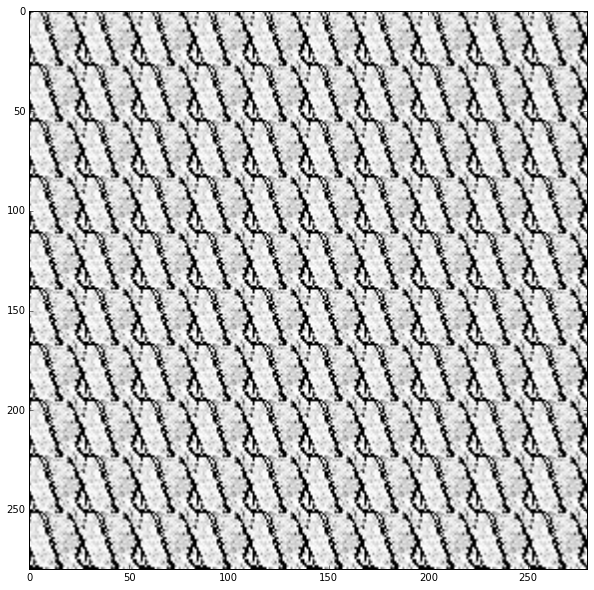

In [174]:
n = 10  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)
zs2 = xp.random.uniform(-1, 1, (batch_size, n_z)).astype(xp.float32)

c_categorical2 = np.zeros((batch_size,30), dtype=np.float32)
for ii in range(100):
    roll=random.randint(0,n_categorical-1)
    c_categorical2[ii]=xtr[roll]
c_categorical2[0,:]=0
c_categorical2[0,:]=xtr[6]

c_continuous2 = xp.asarray(rnd_continuous(100, n_continuous), dtype=xp.float32)
c_continuous2[0,:] = 0
        
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #c_continuous2=np.zeros((100,n_continuous),dtype=np.float32)
        c_continuous2[0,:]=np.array([[yi, xi]], dtype=np.float32)
        c_categorical2[0]=c_categorical2[0]
        zc2 = xp.concatenate((c_categorical2, c_continuous2), axis=1)  
        x_decoded = generator(zc2).data[0]
        digit = x_decoded.reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure,'gray')
plt.show()

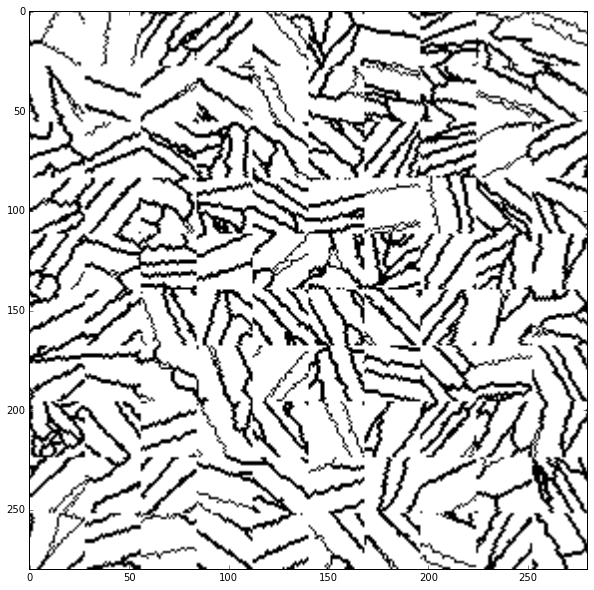

In [180]:
figure_ori = np.zeros((digit_size * n, digit_size * n))
for i in range(10):
    for j in range(10):
        digit = train[j+i*10]
        figure_ori[i * digit_size: (i + 1) * digit_size,j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure_ori,'gray')
plt.show()

In [200]:
# Save the model
import chainer.serializers
chainer.serializers.save_npz('micro_generator',generator)
chainer.serializers.save_npz('micro_discriminator',discriminator)